<a href="https://colab.research.google.com/github/4lparslan/TensorRT/blob/main/TensorRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with CPU, CUDA and TensorRT

### step1: load a pre-trained neural network

In [1]:
import torch
from torchvision import models, transforms

# using gpu
model = models.resnet50(pretrained=True).to("cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 347MB/s]


In [2]:
!wget https://www.linkpicture.com/q/car_2.jpg

--2023-10-12 13:21:36--  https://www.linkpicture.com/q/car_2.jpg
Resolving www.linkpicture.com (www.linkpicture.com)... 104.21.235.181, 104.21.235.182, 2606:4700:3038::6815:ebb5, ...
Connecting to www.linkpicture.com (www.linkpicture.com)|104.21.235.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69670 (68K) [image/jpeg]
Saving to: ‘car_2.jpg’

car_2.jpg           100%[===================>]  68.04K  --.-KB/s    in 0.01s   

2023-10-12 13:21:37 (4.62 MB/s) - ‘car_2.jpg’ saved [69670/69670]



### step 2: load an example image for predition

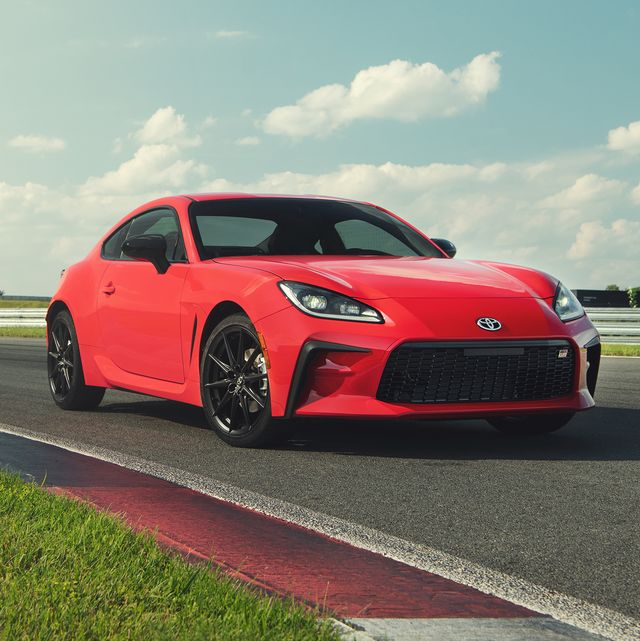

In [3]:
from PIL import Image

img = Image.open("car_2.jpg")
img

### step 3: transform example image (pre-processing)

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

img = transform(img)
print(img.shape)

torch.Size([3, 224, 224])


### step 4: set a batch size to example image

In [5]:
#using gpu
img_batch = torch.unsqueeze(img, 0).to("cuda")
img_batch.shape

torch.Size([1, 3, 224, 224])

### step 5: make a prediction and get probabilities for each class

In [6]:
model.eval()
with torch.no_grad():
    outputs = model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

### step 6: get the names of all available ImageNet classes
source: https://github.com/pytorch/hub/blob/master/imagenet_classes.txt

In [7]:
!pip install pandas

In [8]:
import pandas as pd

categories = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', header=None)
categories[0][2]

'great white shark'

### step 7: extract top 5 probabilities and map them to the appropriate class name

In [9]:
topk = 5

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%93 sports car
%3 racer
%2 car wheel
%1 convertible
%0 grille


### step 8: define a speed test benchmark function & adjust it

source: ResNet50_example.ipynb
<br>
or: https://github.com/NVIDIA/Torch-TensorRT/blob/master/notebooks/Resnet50-example.ipynb

In [10]:
#copy from TRT
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, device="cuda", input_shape=(16, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=100):
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)

    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

### step 10: find out CUDA model speed benchmarks

In [11]:
#CUDA benchmarks
model = model.to("cuda")
benchmark(model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 43.65 ms
Iteration 20/100, ave batch time 44.13 ms
Iteration 30/100, ave batch time 44.07 ms
Iteration 40/100, ave batch time 44.09 ms
Iteration 50/100, ave batch time 44.04 ms
Iteration 60/100, ave batch time 43.98 ms
Iteration 70/100, ave batch time 44.19 ms
Iteration 80/100, ave batch time 44.14 ms
Iteration 90/100, ave batch time 44.24 ms
Iteration 100/100, ave batch time 44.21 ms
Input shape: torch.Size([16, 3, 224, 224])
Output features size: torch.Size([16, 1000])
Average batch time: 44.21 ms


### step 11: trace and compile CUDA model into a TensorRT model

In [12]:
traced_model = torch.jit.trace(model, [torch.randn((16, 3, 224, 224)).to("cuda")])

In [13]:
!pip install torch-tensorrt
!pip3 install nvidia-tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=e84f9269405cfd2b51705b19ef95b5a658884d42ddba94e1eb7805e3406189e7
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [14]:
import torch_tensorrt

trt_model = torch_tensorrt.compile(
    traced_model,
    inputs = [torch_tensorrt.Input((16, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = {torch.float32}
)

### step 12: find out TensorRT model speed benchmarks

In [15]:
benchmark(trt_model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 33.03 ms
Iteration 20/100, ave batch time 32.93 ms
Iteration 30/100, ave batch time 32.84 ms
Iteration 40/100, ave batch time 32.84 ms
Iteration 50/100, ave batch time 32.86 ms
Iteration 60/100, ave batch time 32.89 ms
Iteration 70/100, ave batch time 32.86 ms
Iteration 80/100, ave batch time 32.88 ms
Iteration 90/100, ave batch time 32.87 ms
Iteration 100/100, ave batch time 32.87 ms
Input shape: torch.Size([16, 3, 224, 224])
Output features size: torch.Size([16, 1000])
Average batch time: 32.87 ms


### step 13: make a prediction with the TensorRT model

In [16]:
trt_model.eval()
with torch.no_grad():
    outputs = trt_model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%93 sports car
%3 racer
%2 car wheel
%1 convertible
%0 grille
